# Intro

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. The classes are drawn from the urban sound taxonomy. For a detailed description of the dataset and how it was compiled please refer to our paper.
All excerpts are taken from field recordings uploaded to www.freesound.org. The files are pre-sorted into ten folds (folders named fold1-fold10) to help in the reproduction of and comparison with the automatic classification results reported in the article above.

In addition to the sound excerpts, a CSV file containing metadata about each excerpt is also provided.

### Methodology

1. There are 3 basic methods to extract features from audio file :
    a) Using the mffcs data of the audio files
    b) Using a spectogram image of the audio and then converting the same to data points (As is done for images). This is easily done using mel_spectogram function of Librosa
    c) Combining both features to build a better model. (Requires a lot of time to read and extract data).
2. I have chosen to use the second method.
3. The labels have been converted to categorical data for classification.
4. CNN has been used as the primary layer to classify data

# Importing Necessary Libraries

In [1]:
# Basic Libraries

import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

In [2]:
# Libraries for Classification and building Models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [3]:
# Project Specific Libraries

import os
import librosa
import librosa.display
import glob 
import skimage

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Analysing Data Type and Format

#### Analysing CSV Data

In [15]:
df = pd.read_csv("/content/drive/MyDrive/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv")

'''We will extract classes from this metadata.'''

df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


##### Column Names

* slice_file_name: 
The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
[fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
[classID] = a numeric identifier of the sound class (see description of classID below for further details)
[occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
[sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

* fsID:
The Freesound ID of the recording from which this excerpt (slice) is taken

* start
The start time of the slice in the original Freesound recording

* end:
The end time of slice in the original Freesound recording

* salience:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

* fold:
The fold number (1-10) to which this file has been allocated.

* classID:
A numeric identifier of the sound class:
0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

* class:
The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, 
siren, street_music.

#### Using Librosa to analyse random sound sample - SPECTOGRAM

In [16]:
audio1, sampling_rate1 = librosa.load('/content/6902-2-0-4.wav')
audio2, sampling_rate2 = librosa.load('/content/6902-2-0-5.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

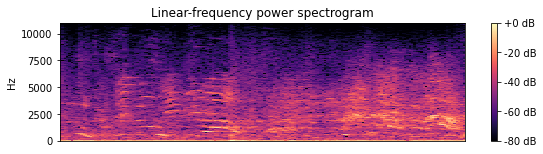

In [17]:
plt.figure(figsize=(20, 10))
wave = librosa.amplitude_to_db(np.abs(librosa.stft(audio1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(wave, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

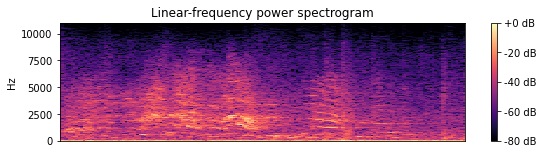

In [18]:
plt.figure(figsize=(20, 10))
wave = librosa.amplitude_to_db(np.abs(librosa.stft(audio2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(wave, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

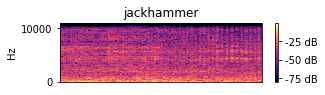

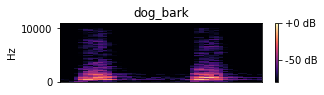

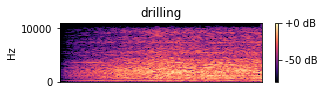

In [19]:
'''Using random samples to observe difference in waveforms.'''

arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(192, 197, 2):
    path = '/content/drive/MyDrive/UrbanSound8K/UrbanSound8K/audio/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

# Feature Extraction and Database Building

#### Method

1. I have used Librosa to extract features.
2. To do so, I will go through each fold and extract the data for each file. Then I have used the mel_spectogram function of librosa to extract the spectogram data as a numpy array.
3. After reshaping and cleaning the data, 75-25 split has been performed.
4. Classes (Y) have been converted to Categorically Encoded Data usng Keras.utils

Note : Running the parser function may take upto 45 minutes depending on your system since it has to extract spectogram data for 8732 audio files

In [20]:
'''EXAMPLE'''

dat1, sampling_rate1 = librosa.load('/content/6902-2-0-4.wav')
arr = librosa.feature.melspectrogram(y=dat1, sr=sampling_rate1)
arr.shape

(128, 173)

In [23]:
feature = []
label = []

def parser(row):
    # Function to load files and extract features
    for i in range(8732):
        file_name = '/content/drive/MyDrive/UrbanSound8K/UrbanSound8K/audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # We extract mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(df["classID"][i])
    return [feature, label]

In [24]:
temp = parser(df)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In [25]:
temp = np.array(temp)
data = temp.transpose()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [38]:
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)
X = np.empty([8732, 128])

(8732,) (8732,)


In [39]:
for i in range(8732):
    X[i] = (X_[i])

In [40]:
Y = to_categorical(Y)

In [41]:
'''Final Data'''
print(X.shape)
print(Y.shape)

(8732, 128)
(8732, 10)


In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

In [43]:
X_train = X_train.reshape(6549, 16, 8, 1)
X_test = X_test.reshape(2183, 16, 8, 1)

In [44]:
input_dim = (16, 8, 1)

# Creating Keras Model and Testing

#### Model 1:

1. CNN 2D with 64 units and tanh activation.
2. MaxPool2D with 2*2 window.
3. CNN 2D with 128 units and tanh activation.
4. MaxPool2D with 2*2 window.
5. Dropout Layer with 0.2 drop probability.
6. DL with 1024 units and tanh activation.
4. DL 10 units with softmax activation.
5. Adam optimizer with categorical_crossentropy loss function.

10 epochs have been used.

In [45]:
model = Sequential()

In [46]:
model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1024, activation = "tanh"))
model.add(Dense(10, activation = "softmax"))

In [47]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [48]:
history = model.fit(X_train, Y_train, epochs = 10, batch_size = 50, validation_data = (X_test, Y_test))

Epoch 1/10
131/131 [==============================] - 13s 7ms/step - loss: 1.5211 - accuracy: 0.4831 - val_loss: 1.2851 - val_accuracy: 0.5662
Epoch 2/10
131/131 [==============================] - 1s 5ms/step - loss: 1.1353 - accuracy: 0.6204 - val_loss: 1.0907 - val_accuracy: 0.6363
Epoch 3/10
131/131 [==============================] - 1s 5ms/step - loss: 0.9523 - accuracy: 0.6770 - val_loss: 0.9909 - val_accuracy: 0.6761
Epoch 4/10
131/131 [==============================] - 1s 5ms/step - loss: 0.8393 - accuracy: 0.7190 - val_loss: 1.0891 - val_accuracy: 0.6509
Epoch 5/10
131/131 [==============================] - 1s 5ms/step - loss: 0.7695 - accuracy: 0.7418 - val_loss: 0.9351 - val_accuracy: 0.7155
Epoch 6/10
131/131 [==============================] - 1s 5ms/step - loss: 0.6992 - accuracy: 0.7655 - val_loss: 0.8015 - val_accuracy: 0.7604
Epoch 7/10
131/131 [==============================] - 1s 5ms/step - loss: 0.6117 - accuracy: 0.7992 - val_loss: 0.8381 - val_accuracy: 0.7380
Epoch

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 16, 8, 64)         640       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 4, 64)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 4, 128)         73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 2, 128)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 4, 2, 128)         0         
                                                                 
 flatten (Flatten)           (None, 1024)             

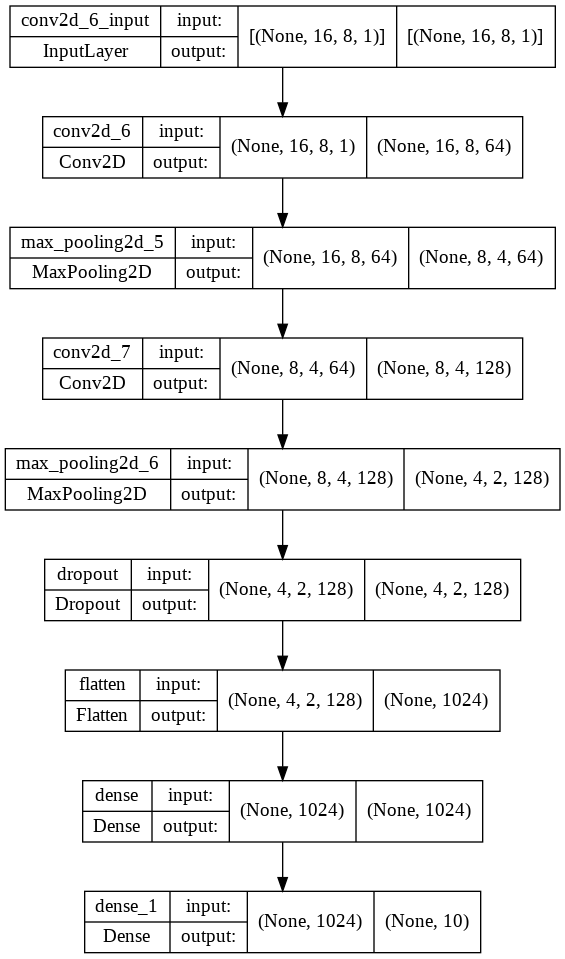

In [53]:
# Test
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [50]:
predictions = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print(score)

69/69 [==============================] - 0s 3ms/step - loss: 0.8540 - accuracy: 0.7554
[0.8540364503860474, 0.7553824782371521]


In [59]:
y_pred_labels = []
for i in predictions:
    y_pred_labels.append(np.argmax(i))

In [63]:
preds = np.argmax(predictions, axis = 1)

In [71]:
preds

array([2, 8, 8, ..., 2, 4, 3])

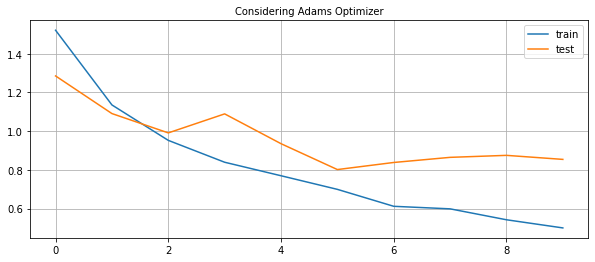

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.grid(True)
plt.legend(fontsize=10)
plt.title('Considering Adams Optimizer', fontsize=10)
plt.show()

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.grid(True)
plt.legend(fontsize=10)
plt.title('Considering Adams Optimizer', fontsize=10)
plt.show()

Text(0.5, 42.0, 'Predicted')

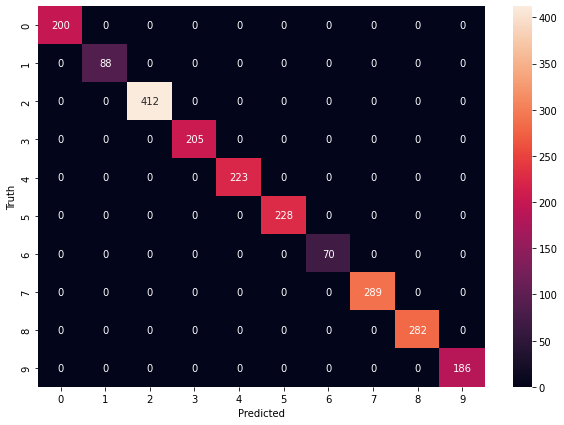

In [81]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix(y_pred_labels, preds), annot = True, fmt = 'd')
plt.ylabel('Truth')
plt.xlabel('Predicted')